In [2]:
import arXiv_rag as ar # local file


In [3]:
from dotenv import load_dotenv
import os
from openai import OpenAI
from dotenv import load_dotenv
from IPython.display import Markdown, display

In [4]:
load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

ping_client = False
#ping_client = True

if ping_client:
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "What is 2 + 2?"}
            ]
        )

        print("✅ Success! Response:")
        print(response.choices[0].message.content)

    except Exception as e:
        print(f"❌ Error: {e}")


### SET THIS TO TRUE IF YOU WANT TO QUERY THE SIMPLE RAG USING THE INTERFACE:

In [6]:
query_simple = False

# Retrieval-Augmented Generation on arXiv Abstracts (`hep-ph`)

This notebook demonstrates a simple RAG (Retrieval-Augmented Generation) system using abstracts from the [arXiv preprint server](https://arxiv.org).

We:
- Fetch recent abstracts from arXiv
- Embed them using a transformer-based sentence encoder
- Store and retrieve embeddings using FAISS
- Use GPT to generate answers from retrieved context

##  FAISS: Facebook AI Similarity Search

FAISS (Facebook AI Similarity Search) is a high-performance library for **efficient similarity search** over dense vector representations. It is especially well-suited for applications like retrieval-augmented generation (RAG), recommendation systems, and nearest-neighbor search in embedding spaces.  

###  How It Works:
- FAISS stores all of our abstract embeddings as vectors in a **vector index**.
- When a user enters a query, we embed it using the same model (`all-MiniLM-L6-v2`).
- FAISS compares the query vector to the stored vectors and returns the **top-k most similar** entries based on distance (usually L2 or cosine).

###  Why We Use FAISS:
- **Speed**: Handles millions of vectors efficiently with GPU/CPU support.
- **Scalability**: Works well for large-scale document search.
- **Simplicity**: Easy to use for exact or approximate nearest neighbor search.

###  In This Project:
- We use `IndexFlatL2` (a brute-force exact search index using Euclidean distance).
- Abstracts are embedded once and stored.
- At query time, FAISS retrieves the most semantically similar papers in milliseconds.

This allows us to build a fast and responsive retrieval system that scales with more data.  Please visit [their gitub](https://github.com/facebookresearch/faiss/wiki/) for more info.


##  Model Overview: `all-MiniLM-L6-v2`

We use the `all-MiniLM-L6-v2` model from the [SentenceTransformers](https://www.sbert.net/) library to convert text into dense vector embeddings. These embeddings represent the **semantic meaning** of text and are used for similarity search in our RAG system.

###  Key Features:
- **Architecture**: MiniLM (6 Transformer layers, distilled from BERT)
- **Embedding Dimension**: 384
- **Speed**: Extremely fast, making it suitable for real-time or large-scale applications
- **Use Case**: Optimized for general-purpose semantic similarity tasks (e.g., question answering, duplicate detection, clustering)

###  Why We Use It:
- Lightweight and fast — ideal for prototyping and scalable applications
- High-quality embeddings despite small size
- Pretrained on a diverse set of tasks like Natural Language Inference (NLI) and Semantic Textual Similarity (STS)

###  Output:
Each input text (e.g., an arXiv abstract or a user query) is mapped to a 384-dimensional vector that can be compared to other vectors using cosine or Euclidean distance.

This model is especially useful for identifying semantically similar scientific texts, even when exact keywords don’t match.


In [8]:
fetch_and_embed_abstracts = True

## Step 1: Fetch Recent arXiv Abstracts

The function fetch_arxiv_abstracts() uses the official arXiv API to fetch recent papers in the `hep-ph` category. 
We store the title, abstract, arXiv ID, and PDF link for each paper.

## Step 2: Embed Abstracts into Semantic Vectors

We use `sentence-transformers` with the model `all-MiniLM-L6-v2` to convert each abstract into an embedding vector. These embeddings capture the semantic meaning of each paper.

## Step 3: Store Embeddings in a FAISS Index

We store the embeddings in a FAISS index for efficient similarity search. Metadata (like titles and abstracts) is saved separately in a JSON file.

If you want to skip this step, set `fetch_and_embed_abstracts` to `False`


In [22]:
if fetch_and_embed_abstracts:
    papers = ar.fetch_arxiv_abstracts(query="hep-ph", max_results=100)
    embeddings = ar.embed_abstracts(papers, show_progress_bar = False)
    ar.store_faiss_index(embeddings, papers)

Stored 100 embeddings in FAISS.


## Step 4: Retrieve Similar Abstracts

Given a user query, we embed it and use FAISS to retrieve the most semantically similar abstracts. These are the most relevant papers to the question being asked.  The default it to return the abstracts



In [24]:
if query_simple:
    query = input("Ask a physics question.  I will return papers with abstracts for you to read: ")
    ppr = ar.retrieve_similar_abstracts(query)

### You can also return just the list of paper titles.

In [26]:
if query_simple:
    query = input("This query will provide a list of titles. Please ask your question: ")
    ppr_titles = ar.retrieve_similar_abstracts(query, include_abstract = False)

## Step 5:  Adding a generative AI componment

For this you are going to need to add your API key to .env and make sure you have tokens:
```python
OPENAI_API_KEY=sk-proj-cy...
``` 

### Model Overview: GPT-4o

**GPT-4o** ("o" for *omni*) is OpenAI's most advanced and versatile model as of 2024. It is optimized for **multimodal reasoning**, supporting text, vision, and audio inputs (though this notebook uses text-only).

Key characteristics:

-  **High Accuracy**: Comparable to GPT-4-turbo in reasoning tasks, with improved response coherence and factuality.
-  **Faster & Cheaper**: Lower latency and cost per token compared to GPT-4-turbo, making it suitable for interactive applications.
-  **Context-Aware**: Supports longer context windows (up to 128k tokens).
-  **Chat-Optimized**: Built for chat-style usage, with conversational memory and role-awareness.

In this notebook, GPT-4o is used to **synthesize answers** from a set of retrieved arXiv abstracts. The model is provided with relevant context and prompted to generate expert-level answers to user queries.

API Pricing:

-  Input: \$0.005 per 1,000 tokens  
-  Output: \$0.015 per 1,000 tokens  

[Token estimator tool](https://platform.openai.com/tokenizer)

#### Asking GPT-4o Questions About Retrieved arXiv Abstracts

This cell demonstrates how to use OpenAI's GPT-4o model to analyze and answer questions based on a set of retrieved arXiv paper abstracts. 

The workflow is as follows:

1. **Retrieve Relevant Abstracts**  
   We use the `retrieve_similar_abstracts()` function to get the top-k papers related to a given query. These papers include metadata such as title and abstract.

2. **Formulate a Research Question**  
   The user provides a natural language question they'd like to answer using the context of the retrieved papers.

3. **Query GPT-4o via API**  
   The function `ask_question_about_abstracts()`:
   - Concatenates all titles and abstracts into a single context string
   - Builds a structured prompt with this context plus the user's question
   - Sends it to the GPT-4o model via the OpenAI API
   - Returns a concise and informed answer grounded in the abstract content

This enables a form of lightweight, domain-specific retrieval-augmented generation (RAG) using just the OpenAI API and local FAISS-based retrieval.


In [28]:
if query_simple:
    answer = ar.ask_question_about_abstracts(ppr, "What is going on with the Higgs Boson these days?")
    #print("GPT-4o's Answer:\n", answer)
    answer = ar.format_for_markdown(answer)
    display(Markdown(f"### GPT-4o's Answer:\n\n{answer}"))

# Retrieval and Rerank

This Model enhances the traditional dense retrieval step by introducing a reranking phase using a more expressive cross-encoder model.

##  What is an Encoder in NLP?

An **Encoder** is a model that transforms input text into a dense vector (embedding) that captures its semantic meaning. Encoders are the backbone of many NLP systems, especially those built on the Transformer architecture (e.g., BERT, RoBERTa).

Encoders enable semantic search by mapping both queries and documents into a shared vector space, where similarity can be measured using cosine similarity or Euclidean distance.

---

##  BiEncoder vs. CrossEncoder

| Type         | Description                                                                 | Performance | Speed     |
|--------------|-----------------------------------------------------------------------------|-------------|-----------|
| **BiEncoder** | Encodes the query and document **separately**. Suitable for fast retrieval. | Lower       | Fast (can precompute) |
| **CrossEncoder** | Encodes the query and document **together**, allowing deep interaction.     | Higher      | Slow (no precompute)  |

- **BiEncoder** (used in retrieval): `all-MiniLM-L6-v2`  
   → Used to embed the query and all abstracts separately for fast FAISS search.

- **CrossEncoder** (used in reranking): `cross-encoder/ms-marco-MiniLM-L-6-v2`  
   → Used to score each query–abstract pair more accurately via token-level attention.

---

## Function: `retrieve_and_rerank(query, initial_k=10, final_k=3)`

This function performs a two-step semantic search:

1. **Retrieve**: 
   - Use a **BiEncoder** to find the top `initial_k` abstracts from the FAISS index.
2. **Rerank**: 
   - Use a **CrossEncoder** to evaluate and sort these top abstracts based on fine-grained semantic relevance to the query.
   - Return the top `final_k` abstracts with highest CrossEncoder scores.

This hybrid approach balances **scalability** (fast retrieval) and **accuracy** (deep reranking).



In [30]:
from IPython.display import display, Markdown, HTML
import warnings
warnings.filterwarnings("ignore")  # Optional to silence general warnings


query = "What is going on with the Higgs Boson?"

# Naive top-k
print("=== Naive Dense Retrieval ===")
papers_naive = ar.retrieve_similar_abstracts(query, k=3)
answer_naive = ar.ask_question_about_abstracts(papers_naive, query)
display(Markdown("**Naive Answer:**\n\n" + ar.format_for_markdown(answer_naive)))

# Retrieve + Rerank
print("=== Retrieve and Rerank ===")
papers_rerank = ar.retrieve_and_rerank(query, initial_k=100, final_k=20)
answer_rerank = ar.ask_question_about_abstracts(papers_rerank, query)
display(Markdown("**Reranked Answer:**\n\n" + ar.format_for_markdown(answer_rerank)))


=== Naive Dense Retrieval ===

Top Matching Abstracts:

--- [1] Multi-boson splashes at future colliders from electroweak compositeness ---
 Abstract: We propose a new collider signature for the composite origin of the
electroweak symmetry breaking of the standard model. The Higgs sector consists
of new fundamental fermions (hyper-quarks), which confine at a hadronization
scale $\Lambda_{HC} \sim$ few TeV. At energies above $\Lambda_{HC}$, the
Drell-Yan production of the hyper-quarks leads to the production of a few
electroweak bosons, in analogy with hadron production in QCD at $e^+e^- \to
q\bar{q}$ around a few GeV. We show that this regime can be probed at future
colliders, namely the proposed 100 TeV hadron collider (FCC-hh) and a 10 TeV
muon collider. Together with the direct discovery of electroweak resonances,
the multi electroweak boson signature provides a smoking gun for Higgs
compositeness.

 arXiv link: http://arxiv.org/pdf/2506.19413v1
—————————————————————————————————————

**Naive Answer:**

The Higgs boson is a central topic in the three research papers you provided, each exploring different aspects of its properties and implications:

1. **Composite Higgs Models**: The first paper discusses a new collider signature related to the composite nature of the Higgs boson. It suggests that the Higgs sector might consist of new fundamental fermions (hyper-quarks) that confine at a scale of a few TeV. This model predicts the production of multiple electroweak bosons at future colliders, which could serve as evidence for Higgs compositeness. This approach aims to explore the origins of electroweak symmetry breaking beyond the Standard Model.

2. **Higher-Order Corrections in Higgs Decays**: The second paper focuses on the decay of the Higgs boson into a pair of W bosons ($h \to WW^*$) and examines the impact of next-to-leading order electroweak corrections on this process. These corrections can alter angular coefficients and introduce new structures that are not present at leading order. The study highlights the stability of the $h \to WW^*$ decay channel under these corrections, which is important for understanding the quantum properties of the Higgs couplings to electroweak gauge bosons.

3. **Higgs Boson and Electroweak Phase Transition**: The third paper investigates a potential 95 GeV mass resonance observed at the LHC and its implications for the electroweak phase transition within the Two Higgs Doublet Model (2HDM). The study explores whether this resonance could be an additional pseudoscalar state and how it might lead to a first-order electroweak phase transition, which is different from the Standard Model's prediction. This has implications for understanding the early universe and phenomena like electroweak baryogenesis, although the gravitational wave signals predicted are below the sensitivity of future experiments.

Overall, these papers reflect ongoing research into the Higgs boson's properties, its role in electroweak symmetry breaking, and its potential to reveal new physics beyond the Standard Model.

=== Retrieve and Rerank ===

Reranked Top Matches:

--- [1] Mono-Higgs signature in a singlet fermionic dark matter model ---
 Abstract: We investigate the production of dark matter in association with a Higgs
boson at the LHC within the singlet fermionic dark matter model. We focus on
final states featuring a Higgs boson accompanied by large missing transverse
momentum ($E^{\textrm{miss}}_{\textrm{T}}$), where the Higgs decays into a $b
\bar{b}$ pair in the ATLAS analysis and into a $ZZ$ pair in the CMS analysis.
Assuming light dark matter fermions with a mass of approximately 1 GeV, we find
that the predicted production yields in this model are compatible with, or even
exceed, those of the benchmark scenarios studied in the recent experimental
analyses, particularly in the low $E^{\textrm{miss}}_{\textrm{T}}$ region,
under parameter sets allowed by current collider bounds and dark matter
constraints. Therefore, we expect that some exclusion limits on the model
parameters introduced i

**Reranked Answer:**

The Higgs boson continues to be a central focus of research in particle physics, with various studies exploring its properties, interactions, and implications for beyond the Standard Model physics. Here are some key themes and findings from recent research papers:

1. **Higgs Couplings and Quantum Properties**: The decay of the Higgs boson into $WW^*$ is being studied for its potential to reveal quantum properties such as entanglement between intermediate gauge bosons. Higher-order corrections to quantum observables in this decay channel are being analyzed to understand the structure of Higgs couplings to electroweak gauge bosons (Paper 2).

2. **Higgs Compositeness**: The concept of Higgs compositeness is being investigated, with new collider signatures proposed to probe the composite origin of electroweak symmetry breaking. Multi-boson production at future colliders could provide evidence for this theory (Paper 3).

3. **Effective Field Theories**: The matching between the Standard Model Effective Field Theory (SMEFT) and the Higgs Effective Field Theory (HEFT) is being studied, particularly in the context of double and triple Higgs production from weak boson fusion. This research aims to understand the implications of effective field theories for collider physics (Paper 7).

4. **Higgs Kinematics and Constraints**: Researchers are using momentum-dependent reweighting strategies to extend LHC analyses within the HEFT framework. This approach aims to probe non-linear Higgs dynamics and assess the sensitivity of various final states to new physics effects (Paper 8).

5. **Dark Sector and Higgs**: The interaction between the Higgs boson and dark matter is being explored in several contexts. For instance, the production of dark matter in association with a Higgs boson is studied in a singlet fermionic dark matter model, with implications for collider searches (Paper 1). Additionally, the dark Higgs mechanism and its impact on dark photon production at colliders are being investigated (Paper 11).

6. **Higgs Pole Inflation**: The role of the Higgs boson in cosmological inflation scenarios is being examined, with loop corrections considered in the context of Higgs pole inflation. These studies aim to reconcile theoretical predictions with observational data (Paper 16).

7. **Electroweak Phase Transition**: The potential for a first-order electroweak phase transition in the Two Higgs Doublet Model (2HD

# Semantic Graph RAG

The Semantic Graph RAG module builds a graph of research papers where edges represent high semantic similarity between abstracts. This is accomplished using the `ar.construct_graph(papers, similarity_threshold=0.7)` function.

### Function: `construct_graph(papers, similarity_threshold=0.7)`

- **Purpose:**  
  Constructs a graph where each node is a paper, and an edge is created between two papers if their abstract embeddings have a cosine similarity above the threshold.

- **Steps:**
  1. Embed each paper's abstract using `all-MiniLM-L6-v2`.
  2. Compute pairwise cosine similarity across all abstracts.
  3. Add nodes for each paper.
  4. Create weighted edges between nodes with similarity ≥ `similarity_threshold`.

- **Returns:**  
  A `networkx.Graph` object where metadata for each paper is attached to the nodes, and the edge weights reflect cosine similarity.

This approach enables clustering, visualization, and graph-based reasoning over sets of related research papers. It is especially useful for identifying dense topical clusters or exploring the connectedness of literature in a given query context.

Graph has 20 nodes and 0 edges


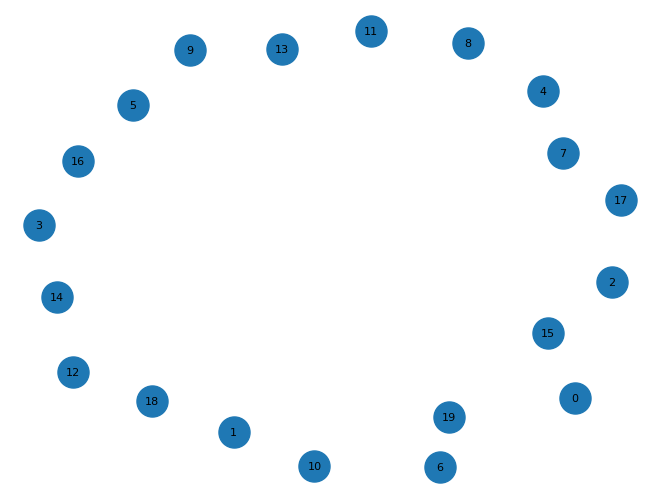

In [32]:
import networkx as nx

# After retrieve_and_rerank(...)
#papers = retrieve_and_rerank(question, initial_k=10, final_k=5)

# Build the similarity graph
G = ar.construct_graph(papers_rerank, similarity_threshold=0.75)

# Inspect graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Optional: Visualize in notebook
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
plt.show()


Graph has 20 nodes and 22 edges


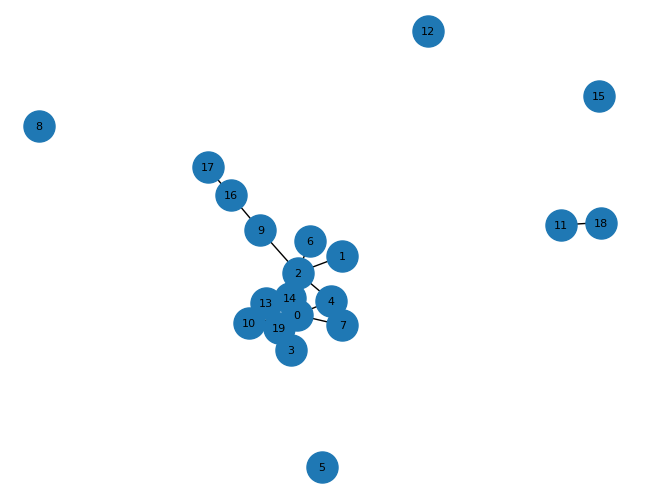

In [33]:
# Build the similarity graph
G = ar.construct_graph(papers_rerank, similarity_threshold=0.6)

# Inspect graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Optional: Visualize in notebook
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
plt.show()

In [34]:
top_pairs = ar.get_top_similar_pairs(papers_rerank, top_n=10)

for i, j, score in top_pairs:
    print(f"[{score:.3f}]")
    print(f"Paper {i+1}: {papers_rerank[i]['title']}")
    print(f"Paper {j+1}: {papers_rerank[j]['title']}")
    print("---")


[0.713]
Paper 1: Mono-Higgs signature in a singlet fermionic dark matter model
Paper 11: Unraveling dark Higgs mechanism via dark photon production at an e^+ e^- collider
---
[0.691]
Paper 1: Mono-Higgs signature in a singlet fermionic dark matter model
Paper 20: A joint explanation for the soft lepton and monojet LHC excesses in the wino-bino model
---
[0.667]
Paper 1: Mono-Higgs signature in a singlet fermionic dark matter model
Paper 14: Constraints on the dark sector from electroweak precision observables
---
[0.658]
Paper 3: Multi-boson splashes at future colliders from electroweak compositeness
Paper 15: Interpreting the 95 GeV resonance in the Two Higgs Doublet Model: Implications for the Electroweak Phase Transition
---
[0.651]
Paper 11: Unraveling dark Higgs mechanism via dark photon production at an e^+ e^- collider
Paper 14: Constraints on the dark sector from electroweak precision observables
---
[0.647]
Paper 10: A Flavor of SO(10) Unification with a Spinor Higgs
Paper 17:

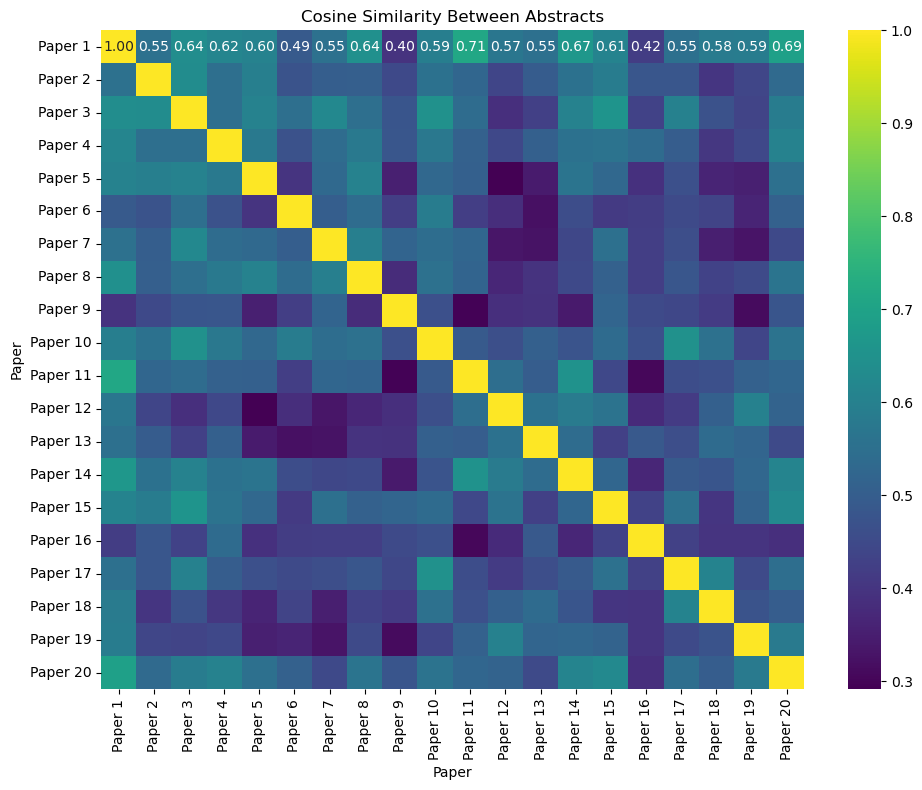

In [35]:
heat_plot = ar.plot_similarity_heatmap(papers_rerank, filename = 'arxiv.png')

# Hybrid RAG

The Hybrid RAG model combines both dense retrieval (using semantic embeddings) and sparse retrieval (using BM25) to balance contextual understanding with exact keyword matching. This is implemented in the function `ar.hybrid_retrieve`.

### Function: `hybrid_retrieve(query, top_k=5, bm25_weight=0.5)`

- **Purpose:**  
  Retrieve the top-k most relevant papers by blending scores from both semantic and keyword-based retrieval methods.

- **Inputs:**
  - `query`: The user's natural language question.
  - `top_k`: Number of papers to return (default: 5).
  - `bm25_weight`: Weight for BM25 scores in the final ranking (default: 0.5). A value closer to 1 favors keyword matching; closer to 0 favors semantic similarity.

- **Steps:**
  1. Compute dense similarity using sentence embeddings and FAISS.
  2. Compute sparse similarity using BM25.
  3. Combine scores with a weighted average.
  4. Return top-k ranked papers.

- **Returns:**  
  A list of top-k paper dictionaries ranked by their hybrid score.

### What is BM25Okapi?

`BM25Okapi` is a classic sparse information retrieval algorithm based on term frequency–inverse document frequency (TF-IDF). It assigns relevance scores by comparing the overlap of query terms with document terms, while accounting for term saturation and document length. In this implementation, we use the `BM25Okapi` class from the `rank_bm25` Python package.

- **Why use it?**  
  BM25 excels at capturing exact or near-exact matches of important keywords — especially effective when queries contain technical terms, acronyms, or rare phrases.

### Comparison with Other RAG Variants

- **Dense-Only RAG** uses embeddings to find semantically similar papers, but may overlook exact term matches.
- **RAG with Reranking** retrieves with embeddings, then refines results using a cross-encoder for better semantic alignment.
- **Hybrid RAG** combines both approaches, leveraging keyword precision (BM25) and contextual similarity (dense embeddings) for more robust retrieval.

This makes Hybrid RAG particularly valuable in scientific and technical domains like arXiv, where both precise terminology and conceptual similarity matter.


In [37]:
# Retrieve + Rerank
print("=== Hybrid ===")
papers_hybrid = ar.hybrid_retrieve(query,  top_k=5, bm25_weight=0.5)
answer_hybrid = ar.ask_question_about_abstracts(papers_rerank, query)
display(Markdown("**Hybrid Answer:**\n\n" + ar.format_for_markdown(answer_rerank)))

=== Hybrid ===


**Hybrid Answer:**

The Higgs boson continues to be a central focus of research in particle physics, with various studies exploring its properties, interactions, and implications for beyond the Standard Model physics. Here are some key themes and findings from recent research papers:

1. **Higgs Couplings and Quantum Properties**: The decay of the Higgs boson into $WW^*$ is being studied for its potential to reveal quantum properties such as entanglement between intermediate gauge bosons. Higher-order corrections to quantum observables in this decay channel are being analyzed to understand the structure of Higgs couplings to electroweak gauge bosons (Paper 2).

2. **Higgs Compositeness**: The concept of Higgs compositeness is being investigated, with new collider signatures proposed to probe the composite origin of electroweak symmetry breaking. Multi-boson production at future colliders could provide evidence for this theory (Paper 3).

3. **Effective Field Theories**: The matching between the Standard Model Effective Field Theory (SMEFT) and the Higgs Effective Field Theory (HEFT) is being studied, particularly in the context of double and triple Higgs production from weak boson fusion. This research aims to understand the implications of effective field theories for collider physics (Paper 7).

4. **Higgs Kinematics and Constraints**: Researchers are using momentum-dependent reweighting strategies to extend LHC analyses within the HEFT framework. This approach aims to probe non-linear Higgs dynamics and assess the sensitivity of various final states to new physics effects (Paper 8).

5. **Dark Sector and Higgs**: The interaction between the Higgs boson and dark matter is being explored in several contexts. For instance, the production of dark matter in association with a Higgs boson is studied in a singlet fermionic dark matter model, with implications for collider searches (Paper 1). Additionally, the dark Higgs mechanism and its impact on dark photon production at colliders are being investigated (Paper 11).

6. **Higgs Pole Inflation**: The role of the Higgs boson in cosmological inflation scenarios is being examined, with loop corrections considered in the context of Higgs pole inflation. These studies aim to reconcile theoretical predictions with observational data (Paper 16).

7. **Electroweak Phase Transition**: The potential for a first-order electroweak phase transition in the Two Higgs Doublet Model (2HD

# Agentic RAG

The Agentic RAG strategy takes a more autonomous and reasoning-driven approach to question answering. Instead of treating the query as a single-step retrieval problem, it uses a multi-step pipeline inspired by how a human researcher might approach a complex question. This is implemented in the function `ar.agentic_rag_answer`.

### Function: `agentic_rag_answer(question, model="gpt-4o", max_tokens=700)`

- **Purpose:**  
  Break down a complex question into manageable sub-questions, retrieve supporting documents for each subtask, summarize them, and synthesize a final answer.

### Key Steps in Agentic RAG:

1. **Decompose the Question**  
   The system prompt instructs GPT-4o to break the user's original question into a sequence of subtasks. Each subtask is treated as a specific information-seeking query.

2. **Document Retrieval per Subquery**  
   For each subtask, the system retrieves relevant papers using reranked dense retrieval (`retrieve_and_rerank`), ensuring high semantic relevance.

3. **Subquestion Answering**  
   GPT-4o is used again to answer each subquestion individually based on the retrieved abstracts and metadata. These form the intermediate building blocks of the final answer.

4. **Final Synthesis**  
   The model receives all intermediate sub-answers and is asked to synthesize a complete, coherent response to the original question — simulating a mini research workflow.

### Why Agentic RAG?

Agentic RAG introduces a reasoning loop. Instead of returning a simple semantic match, it performs structured decomposition and targeted evidence gathering. This has multiple advantages:

- Supports **complex, multi-faceted questions**.
- Enhances **transparency** by showing intermediate reasoning.
- Mimics **expert workflow**, yielding deeper and more accurate responses.
- Is ideal for **research assistance**, literature review, and exploration of nuanced scientific topics.

### Comparison with Other RAG Variants

| Model           | Strategy                             | Best For                                 |
|----------------|--------------------------------------|-------------------------------------------|
| Dense RAG      | One-shot semantic match               | Simple factual questions                  |
| Rerank RAG     | Semantic match + refinement           | Context-aware matching                    |
| Hybrid RAG     | Semantic + keyword matching           | Domain-specific vocabulary                |
| **Agentic RAG**| Multistep reasoning and synthesis     | Complex, layered, or open-ended questions |

Agentic RAG transforms retrieval-augmented generation into a more **interactive, multi-stage reasoning process**, making it the most powerful and intellectually engaging option in this suite.


In [55]:
# Define a complex research question
question = "What are the latest advancements in QCD factorization and how do they impact jet substructure analyses?"

# Run the Agentic RAG pipeline
answer = ar.agentic_rag_answer(question, model="gpt-4o", max_tokens=700)

# Display the answer (optionally render markdown if in a rich notebook environment)
from IPython.display import Markdown, display
display(Markdown(answer))



Reranked Top Matches:

--- [1] Speed of sound of QCD matter at chiral crossover ---
 Abstract: Based on a generalized Beth-Uhlenbeck approach to thermodynamics of QCD
motivated by cluster decomposition we present a unified equation of state of
hot strongly interacting matter and analyze its properties in a wide range of
temperatures. The hadrons are treated as color singlet multiquark clusters in
medium with a background gluon field in the Polyakov gauge. The confining
aspect of QCD is accounted for by the Polyakov loop mechanism and by a large
vacuum quark mass motivated by a confining density functional approach. We
demonstrate that an abrupt switching between hadronic and partonic degrees of
freedom, which is one of striking manifestations of dynamical restoration of
chiral symmetry, is accompanied by a smooth behavior of entropy density at
chiral crossover. Individual contributions of different components of strongly
interacting matter to its speed of sound are analyzed for the fi

The latest advancements in Quantum Chromodynamics (QCD) factorization techniques have significant implications for jet substructure analyses, a crucial area in particle physics aimed at understanding the internal structure of jets produced in high-energy collisions. These advancements are primarily theoretical, focusing on improving the precision and scope of QCD calculations, which in turn enhance the accuracy and efficiency of jet substructure methodologies.

### Theoretical Advancements in QCD Factorization:

1. **Dark Photon Analysis**: Recent studies have incorporated the concept of a dark photon into QCD analyses, which has led to a more comprehensive understanding of electron-nucleon interactions. This integration suggests new physics beyond the Standard Model, potentially impacting how we interpret jet substructure data by introducing new variables or interactions that could manifest in jet properties.

2. **Soft-Collinear Effective Theory (SCET) Applications**: The use of SCET in analyzing baryonic decays represents a significant advancement in understanding QCD processes at different energy scales. This theoretical framework helps in the precise factorization of QCD processes, which is essential for accurately modeling the substructure of jets, particularly in distinguishing between different types of initiating particles.

3. **NNLO QCD Corrections**: The computation of next-to-next-to-leading order (NNLO) QCD corrections has improved the precision of parton distribution and fragmentation functions. These are critical for jet substructure analyses as they provide a more accurate description of the internal structure of jets, aiding in the discrimination between quark-initiated and gluon-initiated jets.

### Practical Impacts on Jet Substructure Analyses:

1. **Enhanced Accuracy**: The integration of these theoretical advancements into jet substructure analyses allows for more precise modeling of jet properties. This is crucial for identifying the origins of jets and distinguishing between different types of particles, such as quarks, gluons, and potential new physics particles like dark photons.

2. **Improved Efficiency**: Techniques like graph-theoretic anomaly detection, inspired by advancements in QCD factorization, offer efficient ways to process and analyze the vast amounts of data generated in collider experiments. These methods reduce computational complexity while maintaining high accuracy, essential for real-time data analysis at facilities like the Large Hadron Collider (LHC).

3. **Broadened Scope**: The advancements allow researchers to explore a wider range of potential new physics scenarios. By providing a model-agnostic framework, these techniques enable the investigation of anomalies or deviations from expected patterns, which could indicate new particles or interactions.

### Conclusion:

The recent advancements in QCD factorization have both theoretical and practical impacts on jet substructure analyses. By enhancing the precision of QCD calculations and introducing novel approaches like SCET and dark photon integration, these advancements improve the accuracy and efficiency of identifying and analyzing jet substructures. This progress not only aids in the search for new physics but also enhances our understanding of fundamental particle interactions, making it a pivotal area of research in high-energy physics.